In [1]:
#! pip install geopandas
#! pip install zipfile

In [2]:
import pandas as pd
import geopandas as gpd
import zipfile 
import os
import matplotlib.pyplot as plt
import sqlite3

In [3]:
df = pd.read_csv("movies_data/countries.csv")
df

,id,country
0,1000001,UK
1,1000001,USA
2,1000002,South Korea
3,1000003,USA
4,1000004,Germany
...,...,...
693471,1941593,China
693472,1941594,USA
693473,1941595,USA
693474,1941596,China


In [4]:
country_counts = df['country'].value_counts().reset_index()
country_counts.columns = ['country', 'count']

In [5]:
df["country"].value_counts()

USA                                  174489
France                                45725
UK                                    42914
Japan                                 41362
Germany                               41325
                                      ...  
Niue                                      2
Heard Island and McDonald Islands         2
Cocos (Keeling) Islands                   1
Norfolk Island                            1
Bouvet Island                             1
Name: country, Length: 247, dtype: int64

In [6]:
#Unzip 
zip_path = 'ne_110m_admin_0_countries.zip'

extract_to = 'data/natural_earth/'

os.makedirs(extract_to, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print("Unzipped successfully!") 

Unzipped successfully!


In [7]:
#Read Data
path = 'data/natural_earth/ne_110m_admin_0_countries.shp'

world = gpd.read_file(path)

#print(world.head())

,featurecla,scalerank,LABELRANK,SOVEREIGNT,SOV_A3,ADM0_DIF,LEVEL,TYPE,TLC,ADMIN,...,FCLASS_TR,FCLASS_ID,FCLASS_PL,FCLASS_GR,FCLASS_IT,FCLASS_NL,FCLASS_SE,FCLASS_BD,FCLASS_UA,geometry
0,Admin-0 country,1,6,Fiji,FJI,0,2,Sovereign country,1,Fiji,...,None,None,None,None,None,None,None,None,None,"MULTIPOLYGON (((180 -16.06713, 180 -16.55522, ..."
1,Admin-0 country,1,3,United Republic of Tanzania,TZA,0,2,Sovereign country,1,United Republic of Tanzania,...,None,None,None,None,None,None,None,None,None,"POLYGON ((33.90371 -0.95, 34.07262 -1.05982, 3..."
2,Admin-0 country,1,7,Western Sahara,SAH,0,2,Indeterminate,1,Western Sahara,...,Unrecognized,Unrecognized,Unrecognized,None,None,Unrecognized,None,None,None,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
3,Admin-0 country,1,2,Canada,CAN,0,2,Sovereign country,1,Canada,...,None,None,None,None,None,None,None,None,None,"MULTIPOLYGON (((-122.84 49, -122.97421 49.0025..."
4,Admin-0 country,1,2,United States of America,US1,1,2,Country,1,United States of America,...,None,None,None,None,None,None,None,None,None,"MULTIPOLYGON (((-122.84 49, -120 49, -117.0312..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
172,Admin-0 country,1,5,Republic of Serbia,SRB,0,2,Sovereign country,1,Republic of Serbia,...,None,None,None,None,None,None,None,None,None,"POLYGON ((18.82982 45.90887, 18.82984 45.90888..."
173,Admin-0 country,1,6,Montenegro,MNE,0,2,Sovereign country,1,Montenegro,...,None,None,None,None,None,None,None,None,None,"POLYGON ((20.0707 42.58863, 19.80161 42.50009,..."
174,Admin-0 country,1,6,Kosovo,KOS,0,2,Disputed,1,Kosovo,...,Admin-0 country,Unrecognized,Admin-0 country,Unrecognized,Admin-0 country,Admin-0 country,Admin-0 country,Admin-0 country,Unrecognized,"POLYGON ((20.59025 41.85541, 20.52295 42.21787..."
175,Admin-0 country,1,5,Trinidad and Tobago,TTO,0,2,Sovereign country,1,Trinidad and Tobago,...,None,None,None,None,None,None,None,None,None,"POLYGON ((-61.68 10.76, -61.105 10.89, -60.895..."


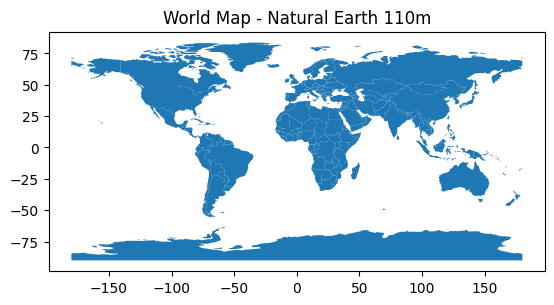

In [8]:
world.plot()
plt.title("World Map - Natural Earth 110m")
#plt.show()
world

In [9]:
name_map = {
    "USA": "United States of America",
    "UK": "United Kingdom",
    "Russian Federation": "Russia",
    "USSR":"Russia",
    "Hong Kong": "China",
    "Czechoslovakia": "Slovakia",
    "East Germany": "Germany",
    "Bolivarian Republic of Venezuela": "Venezuela",
    "State of Palestine": "Palestine",
    "Syrian Arab Republic": "Syria",
    "Lao People's Democratic Republic": "Laos",
    "Republic of Moldova": "Moldova",
    "Democratic Republic of Congo": "Democratic Republic of the Congo"
}
country_counts['country_mapped'] = country_counts['country'].replace(name_map)

In [10]:
country_counts

,country,count,country_mapped
0,USA,174489,United States of America
1,France,45725,France
2,UK,42914,United Kingdom
3,Japan,41362,Japan
4,Germany,41325,Germany
...,...,...,...
242,Niue,2,Niue
243,Heard Island and McDonald Islands,2,Heard Island and McDonald Islands
244,Cocos (Keeling) Islands,1,Cocos (Keeling) Islands
245,Norfolk Island,1,Norfolk Island


In [11]:
country_counts_geo = country_counts.merge(
    world[['ADMIN', 'geometry']],
    left_on='country_mapped',
    right_on='ADMIN',
    how='left'
)

combined = country_counts_geo.groupby('country_mapped', as_index=False).agg({
    'count': 'sum',
    'geometry': 'first'  # since all geometries in group are the same
})


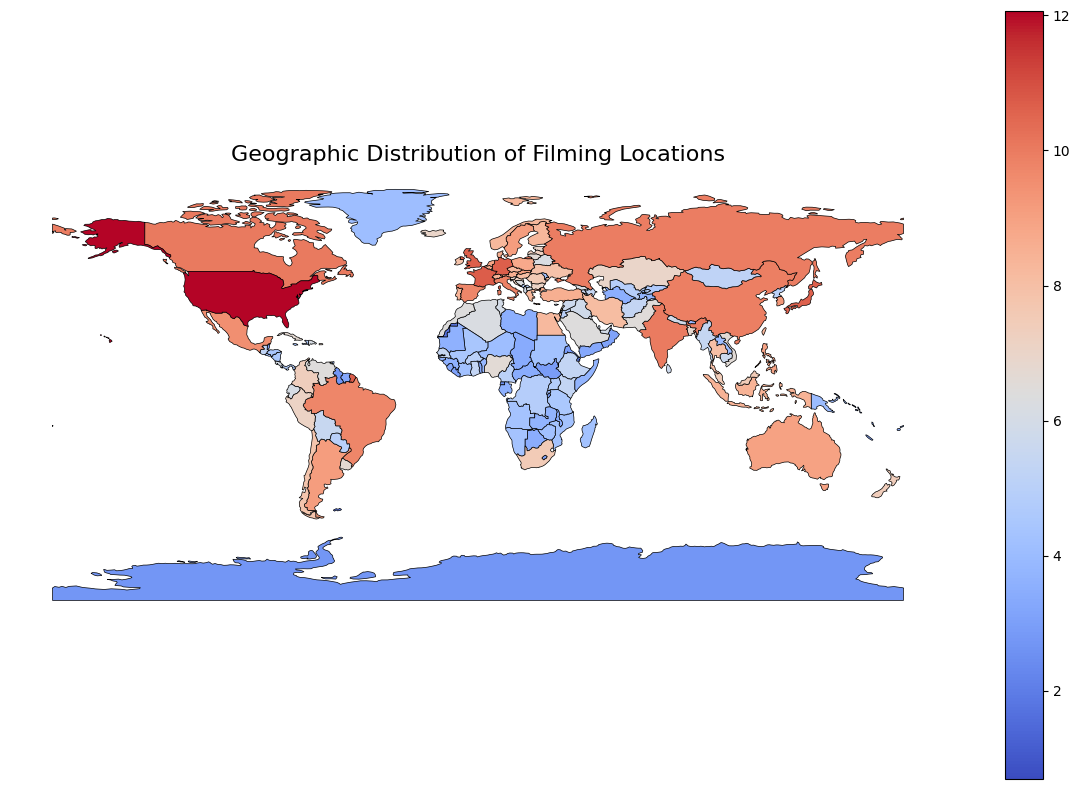

In [12]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np

combined['count_log'] = np.log1p(combined['count'])

combined_df = gpd.GeoDataFrame(combined, geometry='geometry')

# Set CRS if missing
if combined_df.crs is None:
    combined_df.set_crs("EPSG:4326", inplace=True)

# Plot
fig, ax = plt.subplots(figsize=(12, 8))
combined_df.plot(
    column='count_log',
    cmap='coolwarm',
    linewidth=0.5,
    edgecolor='black',
    legend=True,
    missing_kwds={"color": "green", "label": "Missing values"},
    ax=ax
)

ax.set_title('Geographic Distribution of Filming Locations', fontsize=16)
ax.axis('off')
plt.tight_layout()
plt.show()